In [198]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [199]:
class SpinSystem:
    ''' 
    Store a spin system with interaction matrix J, spin state S, and temperature T
    Has methods to update spin-by-spin according to Glauber dynamics

    ...
    
    Attributes
    --------------
    J : np.array(N,N)
        interaction matrix
    S : np.array(N)
        spin array
    T : float
        system temperature
    anneal : boolean
        whether or not to simulate annealing
    anneal_args : float
        argument(s) for decreasing the temperature
    
    Sub-functions
    --------------
    energy()
        returns current value of total energy in the absence of an external field (eqn 3.59)
    decrease_temperature(a = schedule parameter)
        defines the annealing schedule
    update(k = spin index)
        determines whether or not spin k flips and updates the spin array accordingly
        decrease temperature with each step, if annealling is on
    '''
    
    def __init__(self, J, S, T=0, anneal=False, anneal_args=0.005):
        self.J = J
        self.S = S
        self.T = T
        self.anneal = anneal
        self.anneal_args = anneal_args
    
    def energy(self):
        return -0.5*(self.S.dot(self.J.dot(self.S)))
    
    def decrease_temperature(self):
        self.T = self.T/(1 + self.anneal_args*self.T)
    
    def update(self, k):
        delta_E = 2.*self.S[k]*(self.J[k].dot(self.S)) # Change in energy due to flipping spin k (eqn 3.60)
        if self.T > 0:
            flip_prob = np.exp(-delta_E/self.T)
        else:
            flip_prob = 0
        random = np.random.rand()

        if (delta_E < 0) or (random < flip_prob):
            self.S[k] = -self.S[k]
            
        if self.anneal:
            self.decrease_temperature()

# Hopfield Model
Reference: *Neural networks and physical systems with emergent collective computational abilities* by J. J. Hopfield

In [200]:
def hamming_dist(S1, S2):
    ''' Calculate the average bit-by-bit distance between two spin systems S1 and S2 '''
    difference = abs(S1 - S2)
    return np.sum(difference)/2.

def generate_hopf(states):
    ''' Generate interaction matrix to store given states '''

    N = states.shape[1]
    J_hopf = (1/N)*np.transpose(states).dot(states)

    np.fill_diagonal(J_hopf, 0) # make sure the spins don't self-interact
    
    return J_hopf

In [262]:
# Choose a system size
N = 100

# Choose p random states of size N to store
p = 100

# Generate random states to store
stored_states = np.empty((p, N))
for i in range(p):
    stored_states[i] = np.random.choice([-1,1],size=N)
    
J_hopf = generate_hopf(stored_states)

In [276]:
# # Choose a stored state as the initial state
S0 = stored_states[65]

# Choose a random state as the initial state
# S0 = np.random.choice([-1,1],size=N)

T_hopf = 0.

system_hopf = SpinSystem(J_hopf, S0, T_hopf)

In [277]:
total_time = 10*N # how many time steps to take

time = range(total_time)

energies = np.empty(total_time)
magnetizations = np.empty((p, total_time))


for t in time:
    energies[t] = system_hopf.energy()
    
    for i in range(p): # find magnetization for each stored state
        magnetizations[i][t] = (1/N)*stored_states[i].dot(system_hopf.S)
    
    system_hopf.update(t%N) # update spin t mod N

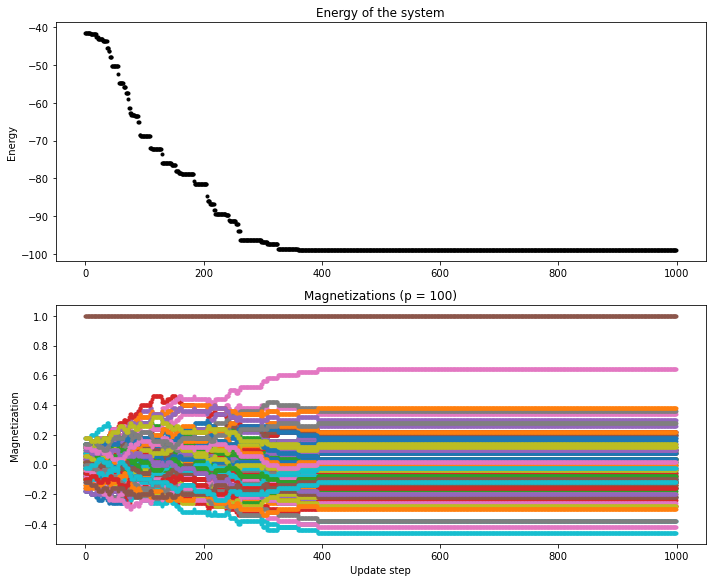

In [278]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title('Energy of the system')
plt.ylabel('Energy')
plt.plot(time, energies, 'k.')

plt.subplot(2, 1, 2)
plt.title('Magnetizations (p = {})'.format(p))
plt.ylabel('Magnetization')
for i in range(p):
    plt.plot(time, magnetizations[i], '.', label="State {}".format(i))
# plt.legend()

plt.tight_layout()
plt.xlabel('Update step')
plt.show()

How many spins will flip next?
0


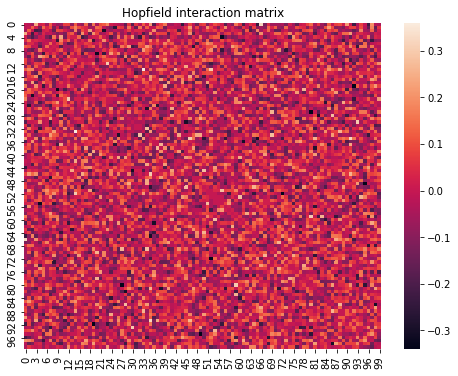

In [269]:
print("How many spins will flip next?")
print(N - np.sum(S0 == np.sign(J_hopf.dot(S0))))
plt.figure(figsize=(8,6))
sb.heatmap(J_hopf)
plt.title("Hopfield interaction matrix")
plt.show()

In [279]:
def find_error(system, state):
    ''' For a given system, evolve and measure final Hamming distance from given state '''
    
    N = len(state)
    total_time = N # how many time steps to take
    time = range(total_time)
    for t in time:
        system.update(t%N) # update spin t mod N
#         print(system.S == np.sign(system.J.dot(system.S)))
        
#     print("How many spins will flip next?")
#     print(N - np.sum(system.S == np.sign(system.J.dot(system.S))))
        
    return hamming_dist(system.S, state)   

In [280]:
N = 100
n = 200

stored_states = np.empty((n, N))
for i in range(n):
    stored_states[i] = np.random.choice([-1,1],size=N)

J_hopf = generate_hopf(stored_states)

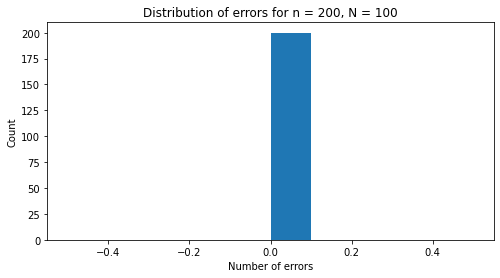

In [281]:
errors = np.zeros(n)
T_hopf = 0.4

amt = 10
# Iterate through all n stored states and see if they eventually have errors
for i in range(n):
    
    for j in range(amt):
        S0 = stored_states[i]
        system_hopf = SpinSystem(J_hopf, S0, T_hopf)
        errors[i] += find_error(system_hopf, S0)/amt
        
plt.figure(figsize=(8, 4))
plt.hist(errors)
plt.title("Distribution of errors for n = {}, N = {}".format(n, N))
plt.ylabel("Count")
plt.xlabel("Number of errors")
plt.show()